In [1]:
import numpy as np

### Creating your own GRN

In [13]:
num_genes = 15
cell_types = 3
master_regulators = 3


In [ ]:
def generate_transition_matrix(size):
    matrix = np.random.rand(size, size)
    matrix /= matrix.sum(axis=1, keepdims=True)  # Normalize each row to sum to 1
    return matrix



In [15]:
# from ortools.sat.python import cp_model

# def build_transition_matrix(cell_types, granularity=100):
#     model = cp_model.CpModel()
#     matrix = []

#     # Create variables for each transition
#     for i in range(cell_types):
#         row = []
#         for j in range(cell_types):
#             if i == j:
#                 # No self-transitions
#                 var = model.NewIntVar(0, 0, f"p_{i}_{j}")
#             else:
#                 var = model.NewIntVar(0, granularity, f"p_{i}_{j}")
#             row.append(var)
#         matrix.append(row)

#     # Create a boolean variable that represents whether a cell is the starting cell
#     start_cell_vars = []
#     for i in range(cell_types):
#         start_cell_vars.append(model.NewBoolVar(f"start_cell_{i}"))

#     # Add constraints to ensure that exactly one cell is the start cell
#     model.Add(sum(start_cell_vars) == 1)

#     # Ensure no transitions into the start cell (column for start cell should have all zeros)
#     for i in range(cell_types):
#         # For each cell, we must have no transitions from other cells into the start cell
#         model.Add(sum(matrix[j][i] for j in range(cell_types) if j != i) == 0).OnlyEnforceIf(start_cell_vars[i])

#     # Ensure the start cell has outgoing transitions (at least one non-zero in the row)
#     for i in range(cell_types):
#         model.Add(sum(matrix[i][j] for j in range(cell_types) if j != i) > 0).OnlyEnforceIf(start_cell_vars[i])

#     for i in range(cell_types):
#         # Whether cell i sends transitions (excluding self)
#         send_vars = [matrix[i][j] for i in range(cell_types) if j != i]
#         send_nonzero = model.NewBoolVar(f"send_{i}")
#         model.Add(sum(send_vars) > 0).OnlyEnforceIf(send_nonzero)
#         model.Add(sum(send_vars) == 0).OnlyEnforceIf(send_nonzero.Not())

#         # Whether cell i receives transitions (excluding self)
#         recv_vars = [matrix[j][i] for j in range(cell_types) if j != i]
#         recv_nonzero = model.NewBoolVar(f"recv_{i}")
#         model.Add(sum(recv_vars) > 0).OnlyEnforceIf(recv_nonzero)
#         model.Add(sum(recv_vars) == 0).OnlyEnforceIf(recv_nonzero.Not())

#         # Must either send or receive
#         model.AddBoolOr([send_nonzero, recv_nonzero])

#     # Solve
#     solver = cp_model.CpSolver()
#     status = solver.Solve(model)

#     if status in [cp_model.FEASIBLE, cp_model.OPTIMAL]:
#         print("Transition Matrix:")
#         result = []
#         for i in range(cell_types):
#             row = []
#             for j in range(cell_types):
#                 val = solver.Value(matrix[i][j]) / granularity
#                 row.append(round(val, 2))
#             result.append(row)
#             print("\t".join(map(str, row)))
#         return result
#     else:
#         print("No solution found.")
#         return None

# # Example: 3 cell types
# build_transition_matrix(cell_types=3)
from ortools.sat.python import cp_model

def build_transition_matrix(cell_types, granularity=100):
    model = cp_model.CpModel()
    
    # Create a cell_types x cell_types matrix of integer variables.
    # Off-diagonal entries (i != j) are in [0, granularity] (representing probabilities scaled by granularity).
    # Diagonal entries (self-transitions) are fixed to 0.
    matrix = []
    for i in range(cell_types):
        row_vars = []
        for j in range(cell_types):
            if i == j:
                var = model.NewIntVar(0, 0, f"p_{i}_{j}")
            else:
                var = model.NewIntVar(0, granularity, f"p_{i}_{j}")
            row_vars.append(var)
        matrix.append(row_vars)
    
    # Create Boolean variables to mark start and terminal cells.
    start_cell = [model.NewBoolVar(f"start_cell_{i}") for i in range(cell_types)]
    terminal_cell = [model.NewBoolVar(f"terminal_cell_{i}") for i in range(cell_types)]
    
    # Exactly one start cell.
    model.Add(sum(start_cell) == 1)
    # Exactly one terminal cell.
    model.Add(sum(terminal_cell) == 1)
    
    # A cell cannot be both start and terminal.
    for i in range(cell_types):
        model.Add(start_cell[i] + terminal_cell[i] <= 1)
    
    # Create ordering variables for acyclicity.
    # They represent a permutation (0 to cell_types-1) and help prevent cycles.
    order = [model.NewIntVar(0, cell_types - 1, f"order_{i}") for i in range(cell_types)]
    model.AddAllDifferent(order)
    
    # For each cell, define its incoming and outgoing sums (excluding self-transitions).
    for i in range(cell_types):
        outgoing = sum(matrix[i][j] for j in range(cell_types) if j != i)
        incoming = sum(matrix[j][i] for j in range(cell_types) if j != i)
        
        # For a start cell: no incoming transitions and full outgoing probability.
        model.Add(incoming == 0).OnlyEnforceIf(start_cell[i])
        model.Add(outgoing > 0).OnlyEnforceIf(start_cell[i])
        
        # For a terminal cell: no outgoing transitions and at least one incoming.
        model.Add(outgoing == 0).OnlyEnforceIf(terminal_cell[i])
        model.Add(incoming > 0).OnlyEnforceIf(terminal_cell[i])
        
        # For any cell that is not terminal, force full outgoing probability.
        model.Add(outgoing == granularity).OnlyEnforceIf(terminal_cell[i].Not())
    
    # Prevent cycles:
    # For every possible transition i->j, if the transition is “active” (i.e. its value > 0),
    # then enforce that order[i] < order[j].
    for i in range(cell_types):
        for j in range(cell_types):
            if i == j:
                continue
            transition_active = model.NewBoolVar(f"transition_{i}_{j}_active")
            model.Add(matrix[i][j] >= 1).OnlyEnforceIf(transition_active)
            model.Add(matrix[i][j] == 0).OnlyEnforceIf(transition_active.Not())
            model.Add(order[i] < order[j]).OnlyEnforceIf(transition_active)
    
    # Solve the model.
    solver = cp_model.CpSolver()
    status = solver.Solve(model)
    
    if status in (cp_model.FEASIBLE, cp_model.OPTIMAL):
        result = []
        print("Transition Matrix:")
        for i in range(cell_types):
            row = []
            for j in range(cell_types):
                val = solver.Value(matrix[i][j]) / granularity  # Convert back to probability
                row.append(round(val, 2))
            result.append(row)
            print("\t".join(map(str, row)))
        print("Start cell:", [i for i in range(cell_types) if solver.Value(start_cell[i])])
        print("Terminal cell:", [i for i in range(cell_types) if solver.Value(terminal_cell[i])])
        print("Order:", [solver.Value(order[i]) for i in range(cell_types)])
        return result
    else:
        print("No solution found")
        return None

# Example usage: Build a 4x4 transition matrix.
build_transition_matrix(cell_types=3)



Transition Matrix:
0.0	1.0	0.0
0.0	0.0	0.0
1.0	0.0	0.0
Start cell: [2]
Terminal cell: [1]
Order: [1, 2, 0]


[[0.0, 1.0, 0.0], [0.0, 0.0, 0.0], [1.0, 0.0, 0.0]]

In [81]:
import numpy as np

def build_transition_matrix(cell_types, granularity=100):
    # Initialize matrix of zeros
    matrix = np.zeros((cell_types, cell_types))
    
    # Randomly assign transitions (non-zero entries less than 1)
    for i in range(cell_types):
        for j in range(cell_types):
            if i != j:  # No self transitions
                matrix[i][j] = np.random.uniform(0, 1)  # Values between 0 and 1
    
    # Ensure that exactly one row is terminal (all zeros)
    terminal_row_idx = np.random.choice(cell_types)
    matrix[terminal_row_idx, :] = 0  # Set the entire row to zero
    
    # Ensure that other rows have at least one non-zero entry
    for i in range(cell_types):
        if i != terminal_row_idx:
            if np.sum(matrix[i, :]) == 0:  # Row has all zeros
                non_terminal_col = np.random.choice(cell_types)
                matrix[i, non_terminal_col] = np.random.uniform(0.01, 1)  # A small positive number
    
    # Ensure that for a terminal row, its corresponding column has non-zero entries
    for j in range(cell_types):
        if np.sum(matrix[:, j]) == 0:  # If the column j has all zeros
            non_terminal_row = np.random.choice([k for k in range(cell_types) if k != terminal_row_idx])
            matrix[non_terminal_row, j] = np.random.uniform(0.01, 1)  # A small positive number
    
    return matrix

# Example: 3 cell types
transition_matrix = build_transition_matrix(3)

# Display the matrix
print("Transition Matrix:")
print(transition_matrix)


Transition Matrix:
[[0.         0.67739934 0.97767144]
 [0.         0.         0.        ]
 [0.26539152 0.07749516 0.        ]]


In [14]:
import random

def generate_grn(num_genes, edge_prob=0.3,
                 upreg_range=(0.5, 5.0), downreg_range=(0.5, 5.0),
                 scalar=2.0):
    """
    Generate a random gene regulatory network with the following columns for each edge:
      (target gene, type of regulation, affector gene, regulation magnitude, scalar)
    
    The network is built so that it is balanced:
      - First, each gene is randomly assigned to one of two groups (0 or 1).
      - Then, for any edge (from affector gene to target gene):
          * If the affector and target are in the same group, the interaction is positive.
          * If they are in different groups, the interaction is negative.
    
    edge_prob: probability of including an edge between any two distinct genes.
    upreg_range: range (min, max) from which to sample a positive regulation magnitude.
    downreg_range: range (min, max) from which to sample a (absolute) magnitude for negative regulation.
    scalar: the constant scalar value for every interaction.
    
    Returns:
      interactions: a list of interactions (tuples) in the format described.
      groups: a dict mapping each gene (0-indexed) to its assigned group.
    """
    # Randomly assign each gene to group 0 or 1.
    groups = {gene: random.choice([0, 1]) for gene in range(num_genes)}
    
    interactions = []
    # Iterate over all possible ordered pairs (affector, target); no self-loops.
    for affector in range(num_genes):
        for target in range(num_genes):
            if affector == target:
                continue
            if random.random() < edge_prob:
                # Determine the sign and magnitude based on the group assignment.
                if groups[affector] == groups[target]:
                    # Same group → upregulation: positive magnitude.
                    mag = round(random.uniform(*upreg_range), 2)
                else:
                    # Different groups → downregulation: negative magnitude.
                    mag = -round(random.uniform(*downreg_range), 2)
                # In the interactions file, the columns are:
                #   (target gene, type of regulation, affector gene, regulation magnitude, scalar)
                # Here, type of regulation is set to 1 by default.
                interactions.append((target, 1, affector, mag, scalar))
    
    return interactions, groups

# Example usage:
num_genes = 10          # Adjust number of genes as desired.
edge_probability = 0.3  # Adjust density (probability of including an edge).

interactions, gene_groups = generate_grn(num_genes, edge_prob=edge_probability)

print("Gene Group Assignments:")
for gene, grp in sorted(gene_groups.items()):
    print(f"  Gene {gene}: Group {grp}")

print("\nGenerated Gene Regulatory Interactions:")
print("Format: (target gene, type, affector gene, regulation magnitude, scalar)")
for inter in interactions:
    print(",".join(map(str, inter)))


Gene Group Assignments:
  Gene 0: Group 1
  Gene 1: Group 0
  Gene 2: Group 0
  Gene 3: Group 0
  Gene 4: Group 0
  Gene 5: Group 0
  Gene 6: Group 1
  Gene 7: Group 1
  Gene 8: Group 1
  Gene 9: Group 1

Generated Gene Regulatory Interactions:
Format: (target gene, type, affector gene, regulation magnitude, scalar)
2,1,0,-4.23,2.0
3,1,0,-2.85,2.0
5,1,0,-3.66,2.0
6,1,0,4.16,2.0
7,1,0,3.95,2.0
3,1,1,4.91,2.0
4,1,1,4.47,2.0
5,1,1,4.96,2.0
0,1,2,-2.25,2.0
1,1,2,1.31,2.0
4,1,2,4.53,2.0
9,1,2,-0.62,2.0
2,1,3,2.19,2.0
9,1,3,-2.76,2.0
3,1,4,0.64,2.0
7,1,4,-1.35,2.0
8,1,4,-1.11,2.0
7,1,5,-4.13,2.0
8,1,5,-3.04,2.0
1,1,6,-4.16,2.0
0,1,7,1.24,2.0
1,1,7,-1.52,2.0
2,1,7,-2.55,2.0
4,1,7,-4.92,2.0
0,1,8,2.93,2.0
1,1,9,-3.66,2.0
4,1,9,-2.93,2.0
8,1,9,1.75,2.0


/var/folders/6s/mn0cx1qn7b901qdgrbh6z_hm0000gp/T/ipykernel_60543/1034545610.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


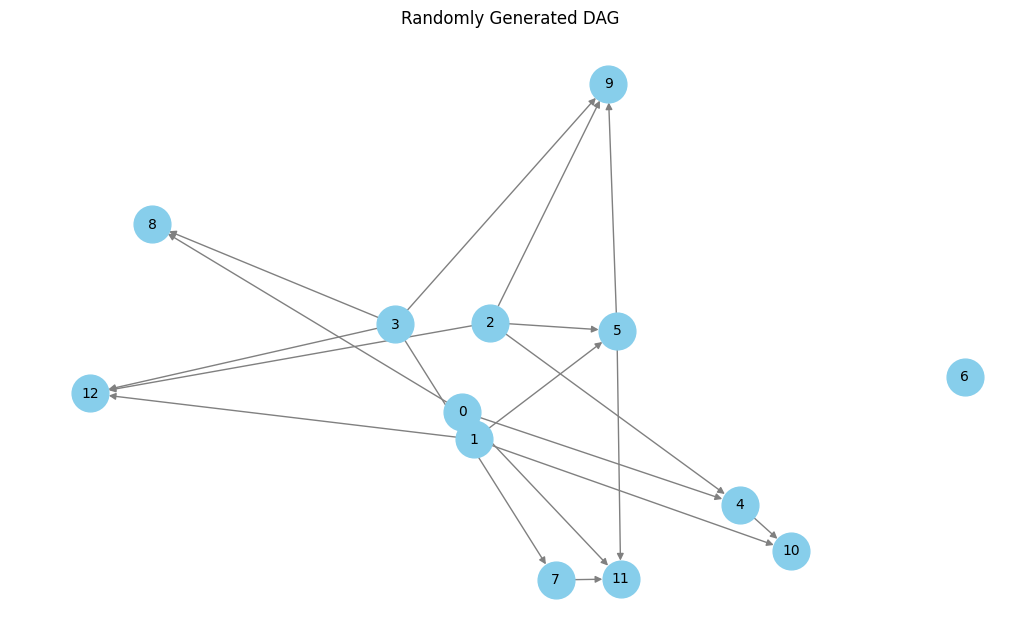

In [22]:
import random
import time
import networkx as nx
import matplotlib.pyplot as plt

# Constants
MIN_PER_RANK = 1
MAX_PER_RANK = 5
MIN_RANKS = 3
MAX_RANKS = 5
PERCENT = 30

def generate_random_dag_graph():
    random.seed(time.time())

    G = nx.DiGraph()
    nodes = 0
    ranks = random.randint(MIN_RANKS, MAX_RANKS)

    for _ in range(ranks):
        new_nodes = random.randint(MIN_PER_RANK, MAX_PER_RANK)

        for j in range(nodes):
            for k in range(new_nodes):
                if random.randint(0, 99) < PERCENT:
                    G.add_edge(j, k + nodes)

        for k in range(new_nodes):
            G.add_node(k + nodes)

        nodes += new_nodes

    return G

def visualize_dag(G):
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)  # You can try nx.kamada_kawai_layout or shell_layout
    nx.draw(G, pos, with_labels=True, node_color='skyblue', arrows=True, 
            node_size=700, font_size=10, edge_color='gray', arrowstyle='-|>')
    plt.title("Randomly Generated DAG")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    dag = generate_random_dag_graph()
    visualize_dag(dag)
